In [277]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import random
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F
import math
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [278]:
def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [270]:
# DATA TEST
data = []
label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
for ID in range(1000):
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
    data.append(Y[1][0]/3.1415926)


KeyboardInterrupt: 

In [279]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[1][0]/3.1415926
            Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y

In [286]:
all_ids = [str(i) for i in  list(np.arange(0,10000,1))]
train_ids = all_ids[:800]
val_ids   = all_ids[800:1000]
params = {
    'batch_size'  : 256,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [65]:
# data loader test
data = np.array([])
for batch in validation_generator:
    data = np.append(data, batch[1][:,0])

In [281]:
for batch in training_generator:
    break
batch[1].shape

torch.Size([32, 1])

tensor([0.4313])

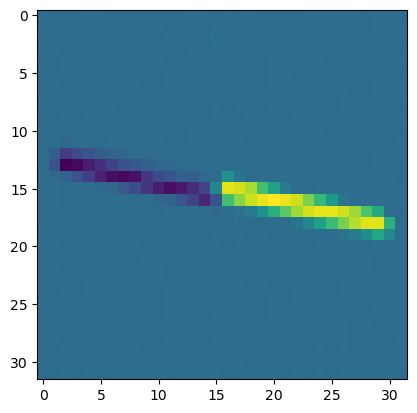

In [282]:
plt.imshow(batch[0][7][0])
batch[1][7]

tensor([0.5860])

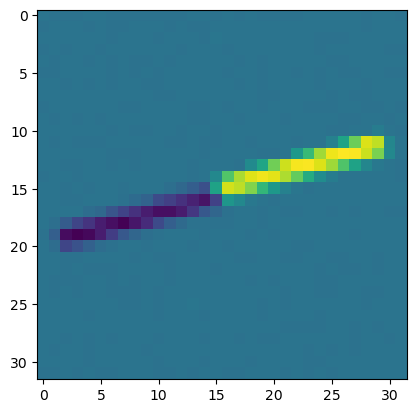

In [41]:
plt.imshow(batch[0][4][0])
batch[1][4]

In [283]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [77]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(3)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

In [78]:
del model

In [79]:
model = Network()
no_of_params(model)

25295

In [80]:
lr = 1e-6
wd = 1e-4
epochs = 100
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd
    )

gamma = 0.9#0.85
scheduler_step_size = 1
scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size = scheduler_step_size, 
    gamma     = gamma)

# scheduler = lr_scheduler.ExponentialLR(
#     optimizer, 
#     #step_size = scheduler_step_size, 
#     gamma     = gamma)

In [81]:
train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

EPOCH:  1  Train loss:  0.3332  Val loss:  0.1558  LR:  9e-07
EPOCH:  2  Train loss:  0.2848  Val loss:  0.2641  LR:  8.1e-07
EPOCH:  3  Train loss:  0.2388  Val loss:  0.2421  LR:  7.29e-07
EPOCH:  4  Train loss:  0.1995  Val loss:  0.1855  LR:  6.561e-07
EPOCH:  5  Train loss:  0.1682  Val loss:  0.1574  LR:  5.905e-07
EPOCH:  6  Train loss:  0.1421  Val loss:  0.1452  LR:  5.314e-07
EPOCH:  7  Train loss:  0.1217  Val loss:  0.1134  LR:  4.783e-07
EPOCH:  8  Train loss:  0.1051  Val loss:  0.1124  LR:  4.305e-07
EPOCH:  9  Train loss:  0.0925  Val loss:  0.1001  LR:  3.874e-07
EPOCH:  10  Train loss:  0.0817  Val loss:  0.0813  LR:  3.487e-07
EPOCH:  11  Train loss:  0.0733  Val loss:  0.0721  LR:  3.138e-07
EPOCH:  12  Train loss:  0.0668  Val loss:  0.0744  LR:  2.824e-07
EPOCH:  13  Train loss:  0.0609  Val loss:  0.0707  LR:  2.542e-07
EPOCH:  14  Train loss:  0.0566  Val loss:  0.0616  LR:  2.288e-07
EPOCH:  15  Train loss:  0.0531  Val loss:  0.0609  LR:  2.059e-07
EPOCH:  16 

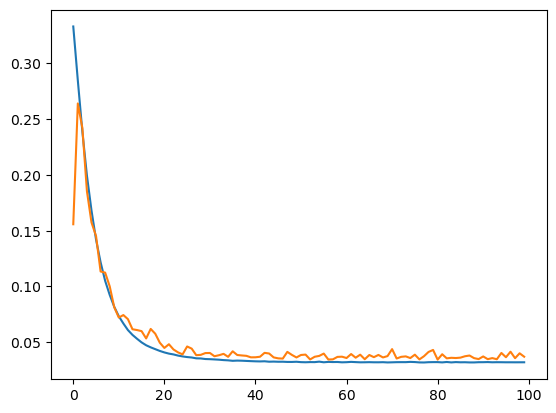

In [84]:
plt.plot(train_losses)
plt.plot(val_losses)

In [99]:
i = 0
for batch in validation_generator:
    break
#     i+= 1
#     if i == 2:
#         break
output = model(batch[0])
output

tensor([[0.3371],
        [0.2794],
        [0.2867],
        [0.3771],
        [0.3115],
        [0.3186],
        [0.2738],
        [0.3985],
        [0.3137],
        [0.3938],
        [0.2606],
        [0.3135],
        [0.2780],
        [0.2954],
        [0.3111],
        [0.3405],
        [0.3129],
        [0.2797],
        [0.3128],
        [0.3003],
        [0.3087],
        [0.3172],
        [0.4164],
        [0.3769],
        [0.3028],
        [0.3027],
        [0.2708],
        [0.3106],
        [0.4391],
        [0.2960],
        [0.2580],
        [0.2757]], grad_fn=<AddmmBackward0>)

In [100]:
batch[1]

tensor([[0.1466],
        [0.9174],
        [0.0906],
        [0.6451],
        [0.4376],
        [0.3292],
        [0.7543],
        [0.6370],
        [0.9653],
        [0.2891],
        [0.7931],
        [0.2457],
        [0.0723],
        [0.9963],
        [0.5235],
        [0.5699],
        [0.5146],
        [0.9139],
        [0.3366],
        [0.1018],
        [0.3382],
        [0.4484],
        [0.6309],
        [0.6448],
        [0.3670],
        [0.4705],
        [0.0548],
        [0.1944],
        [0.6233],
        [0.3727],
        [0.8120],
        [0.8978]])

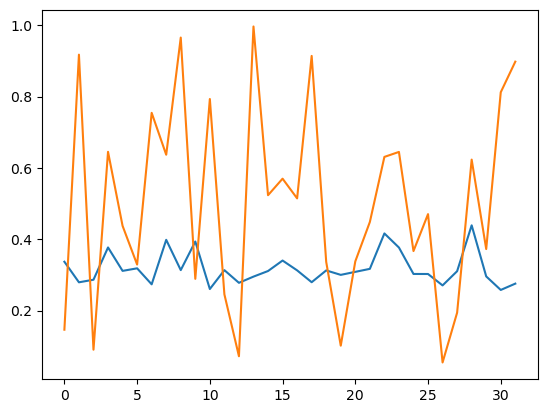

In [101]:
plt.plot(output.detach().numpy())
plt.plot(batch[1].detach().numpy())

## using vision transformers

In [105]:
from vit_pytorch import ViT
model = ViT(
        image_size  = 32,#256,
        channels    = 1,#1,
        patch_size  = 16,
        num_classes = 1,
        dim         = 32,
        depth       = 2,
        heads       = 4,
        mlp_dim     = 64,
        dropout     = 0.1,
        emb_dropout = 0.1,
    )
no_of_params(model)

83329

In [107]:
lr = 1e-5
wd = 1e-4
epochs = 50
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd
    )

gamma = 1#0.85
scheduler_step_size = 1
scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size = scheduler_step_size, 
    gamma     = gamma)

# scheduler = lr_scheduler.ExponentialLR(
#     optimizer, 
#     #step_size = scheduler_step_size, 
#     gamma     = gamma)

In [108]:
train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

EPOCH:  1  Train loss:  0.1565  Val loss:  0.1241  LR:  1e-05
EPOCH:  2  Train loss:  0.1266  Val loss:  0.0841  LR:  1e-05
EPOCH:  3  Train loss:  0.0966  Val loss:  0.0798  LR:  1e-05
EPOCH:  4  Train loss:  0.0882  Val loss:  0.0846  LR:  1e-05
EPOCH:  5  Train loss:  0.0865  Val loss:  0.0998  LR:  1e-05
EPOCH:  6  Train loss:  0.084  Val loss:  0.0834  LR:  1e-05
EPOCH:  7  Train loss:  0.0759  Val loss:  0.062  LR:  1e-05
EPOCH:  8  Train loss:  0.0596  Val loss:  0.0402  LR:  1e-05
EPOCH:  9  Train loss:  0.0455  Val loss:  0.0256  LR:  1e-05
EPOCH:  10  Train loss:  0.0376  Val loss:  0.018  LR:  1e-05
EPOCH:  11  Train loss:  0.0356  Val loss:  0.0214  LR:  1e-05
EPOCH:  12  Train loss:  0.0368  Val loss:  0.0274  LR:  1e-05
EPOCH:  13  Train loss:  0.0421  Val loss:  0.0338  LR:  1e-05
EPOCH:  14  Train loss:  0.0437  Val loss:  0.0246  LR:  1e-05
EPOCH:  15  Train loss:  0.0334  Val loss:  0.0184  LR:  1e-05
EPOCH:  16  Train loss:  0.0241  Val loss:  0.0146  LR:  1e-05
EPOC

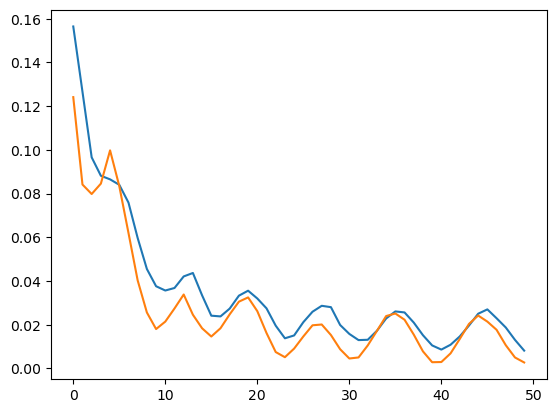

In [184]:
plt.plot(train_losses)
plt.plot(val_losses)

In [194]:
for batch in validation_generator:
    break
output = model(batch[0])
output

tensor([[0.2313],
        [0.7002],
        [0.8771],
        [0.8399],
        [0.8380],
        [0.8383],
        [0.9046],
        [0.4039],
        [0.2047],
        [0.9226],
        [0.7392],
        [0.8073],
        [0.2144],
        [0.8871],
        [0.2120],
        [0.2152],
        [0.5049],
        [0.3115],
        [0.5058],
        [0.2310],
        [0.2892],
        [0.8780],
        [0.4191],
        [0.7251],
        [0.0286],
        [0.3327],
        [0.8306],
        [0.3708],
        [0.7064],
        [0.9655],
        [0.2505],
        [0.9796]], grad_fn=<AddmmBackward0>)

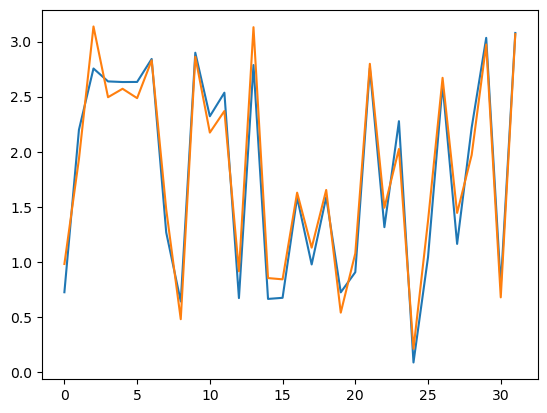

In [195]:
plt.plot(output.detach().numpy()*3.1415926)
plt.plot(batch[1].detach().numpy()*3.1415926)

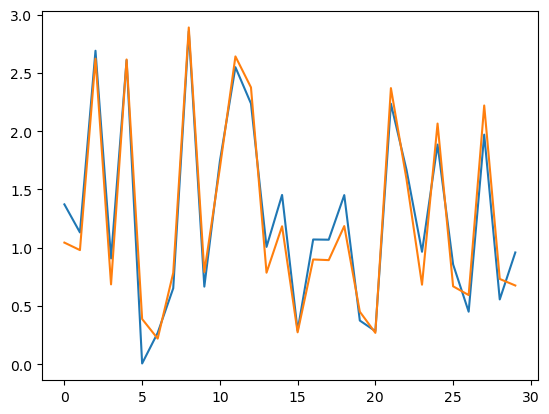

In [209]:
plt.plot(real)
plt.plot(outputs)

1.3720744748423945


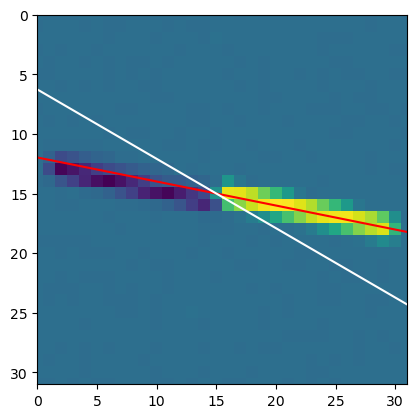

1.1313778303866853


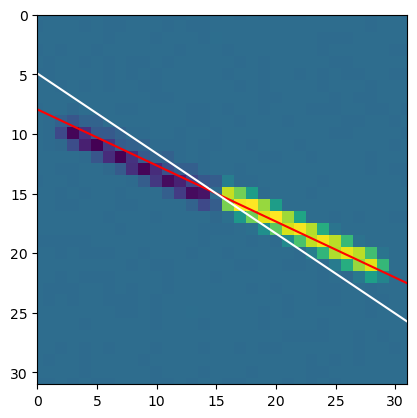

2.6899504048030347


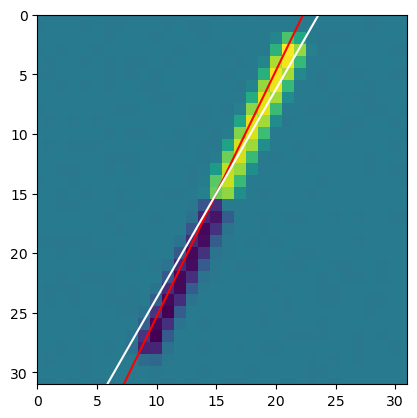

0.908378979974079


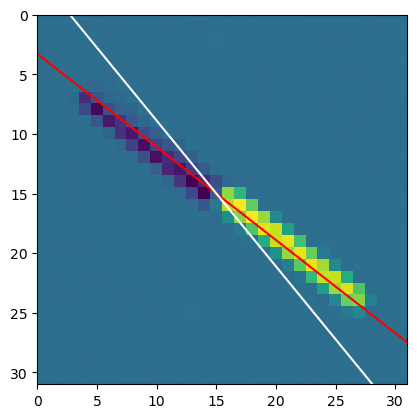

2.608581582474915


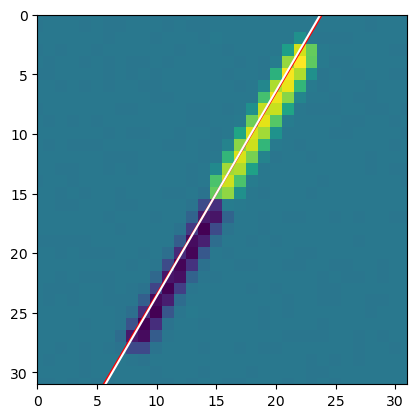

0.007350592228349078


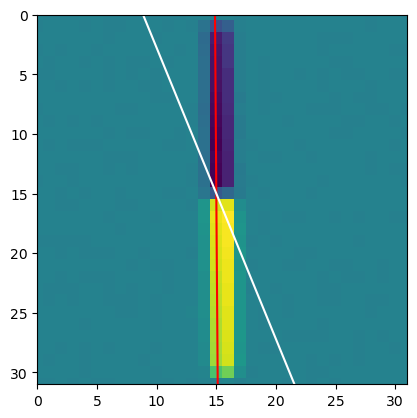

0.27019382123525015


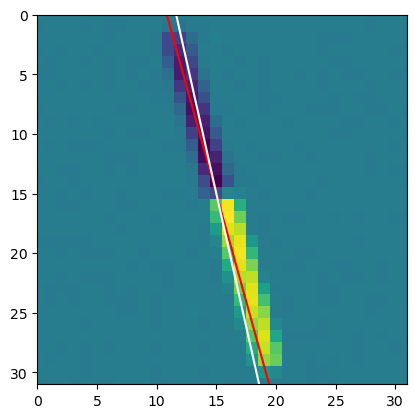

0.6522600621462805


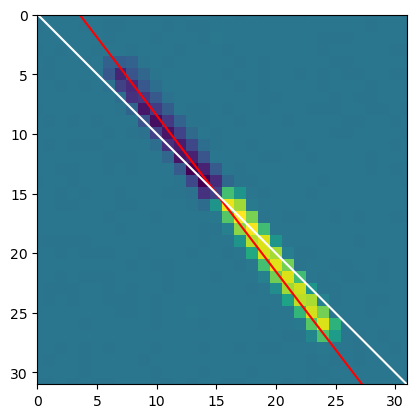

2.8571634989648143


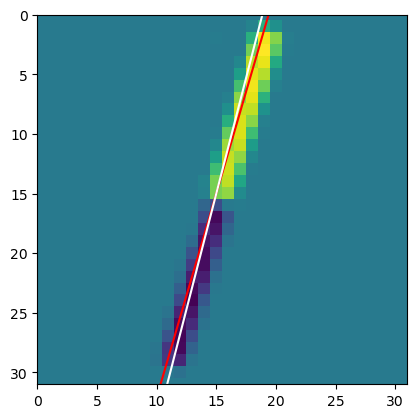

0.6666157404199168


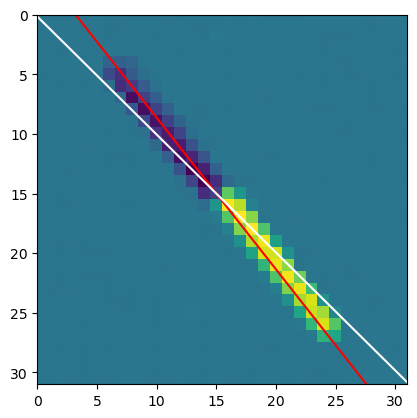

1.7414147580825936


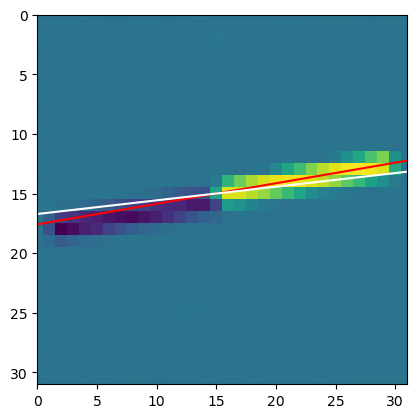

2.548877536555732


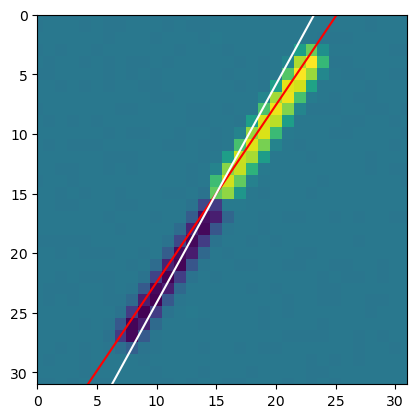

2.236906938178675


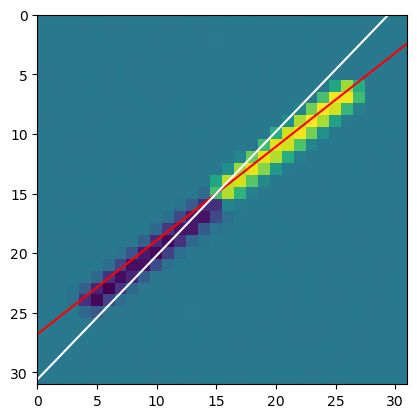

1.0073262988529672


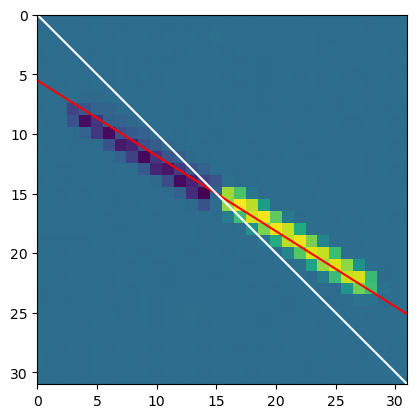

1.4530496371842372


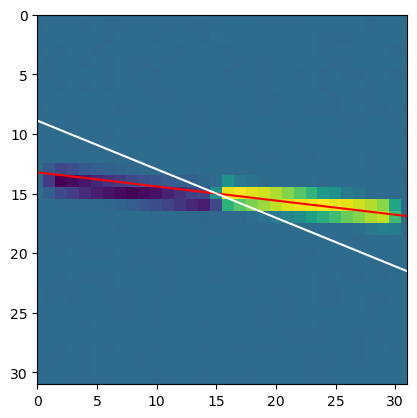

0.2890796673581022


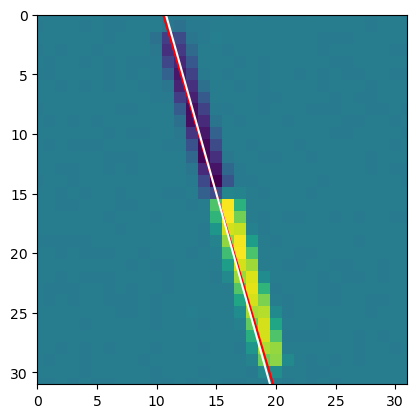

1.070877914012899


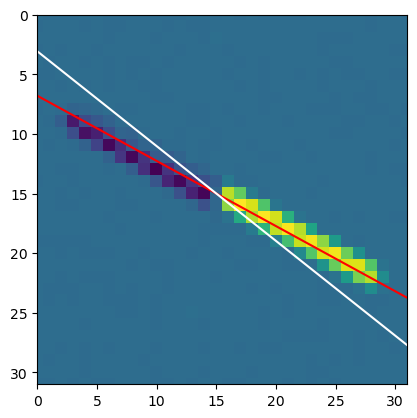

1.0691084403112687


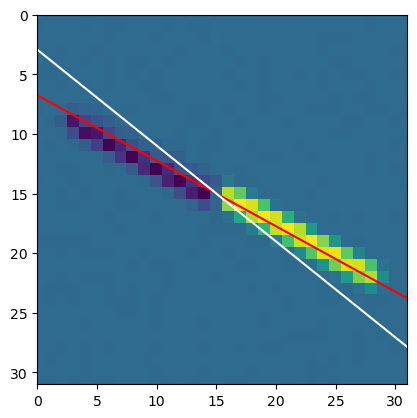

1.4516991793547824


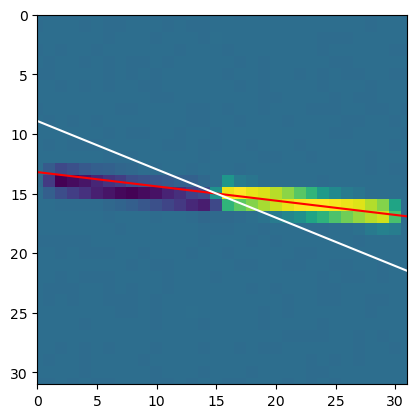

0.37564643986513546


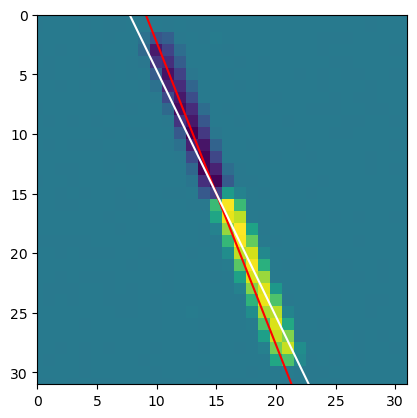

0.2846546707581092


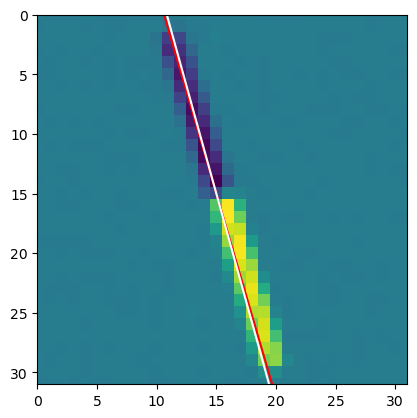

2.2352003981084816


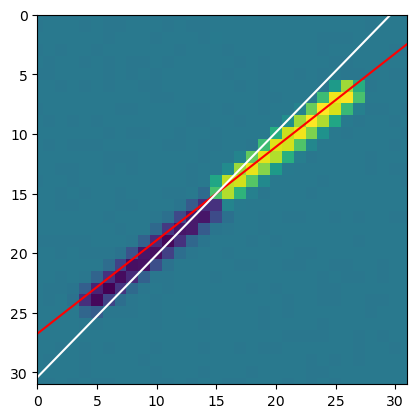

1.6700501141490938


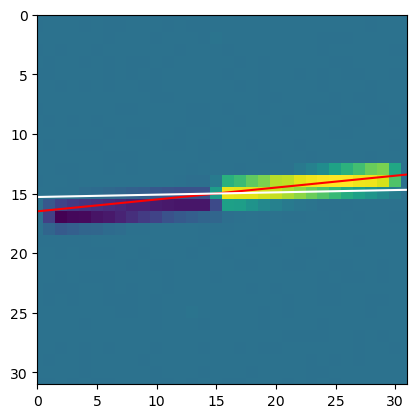

0.965615879077217


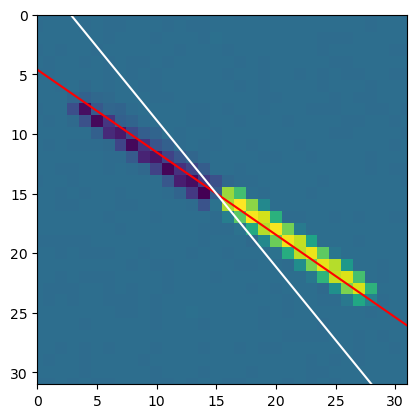

1.885089070525308


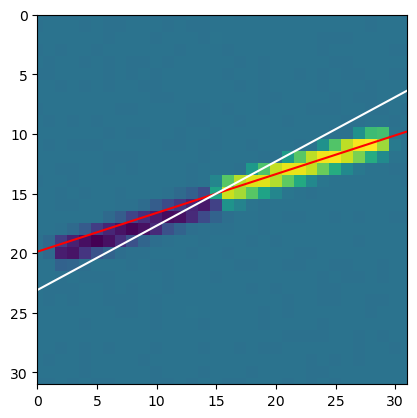

0.8573588514604354


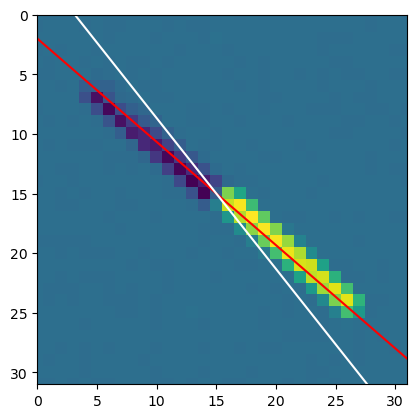

0.4514761816897453


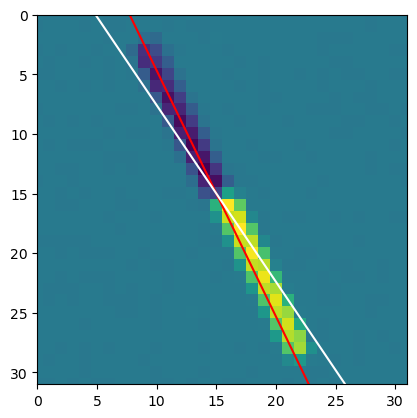

1.9702840258046068


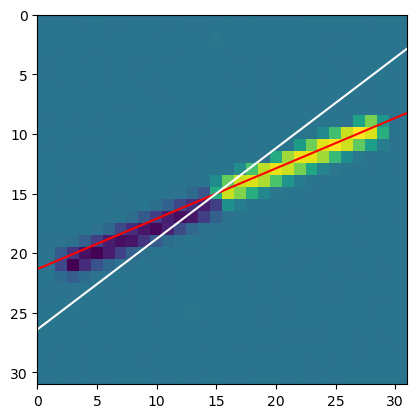

0.5566515247235164


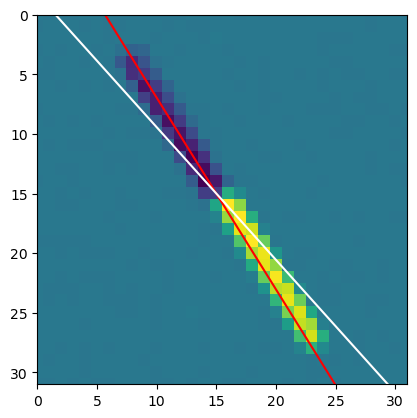

0.9595688311438694


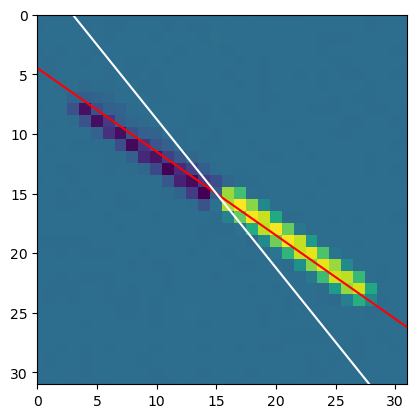

In [208]:
test_IDs = [ random.randint(0,999) for i in range(100) ]

real = []
outputs = []
for ID in test_IDs[:30]:
    input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
    label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
    
    X = torchvision.io.read_image(
                input_dir + str(ID) + ".png "
            ).to(torch.float32)
    plt.imshow(X[1])
    X = X/256.
    
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
        Y = Y[1][0]#/3.1415926
        
    output = float(model(X[1].unsqueeze(0).unsqueeze(0)))*3.1415926
    
    print(Y)
    
    real.append(Y)
    outputs.append(output)
    
    #plt.plot( [16 - 50*math.tan(Y),16 ,16 + 50*math.tan(Y)],[16 - 50, 16,16 + 50], c='r')
    plt.plot( [15 - 50*math.tan(Y),15 ,15 + 50*math.tan(Y)],[15 - 50, 15,15 + 50], c='r')
    plt.plot( [15 - 50*math.tan(output),15 ,15 + 50*math.tan(output)],[15 - 50, 15,15 + 50], c='w')
    
    plt.xlim(0,31)
    plt.ylim(31,0)
    
    #plt.axvline( x = (Y + 1)*16, c='w' )
    #plt.axvline( x = (output + 1.)*16, c='r')
    plt.show()
    
        

In [219]:
import torch.nn.functional as F

In [258]:
del model

In [287]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
no_of_params(model)

60941

In [294]:
# current best
# 1e-4
# 1e-6

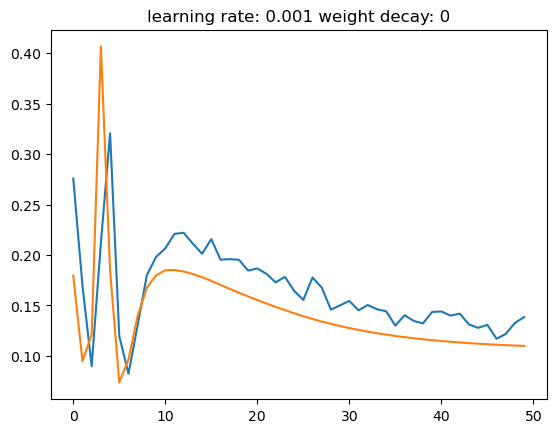

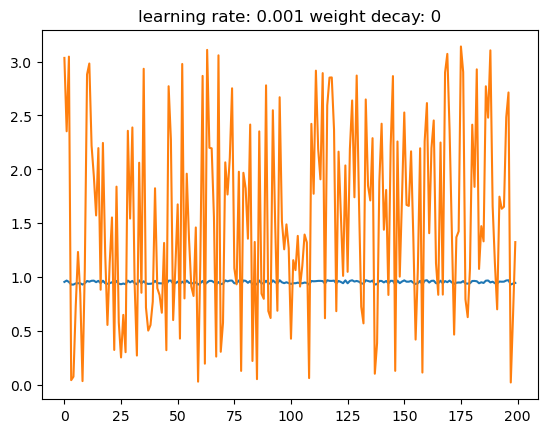

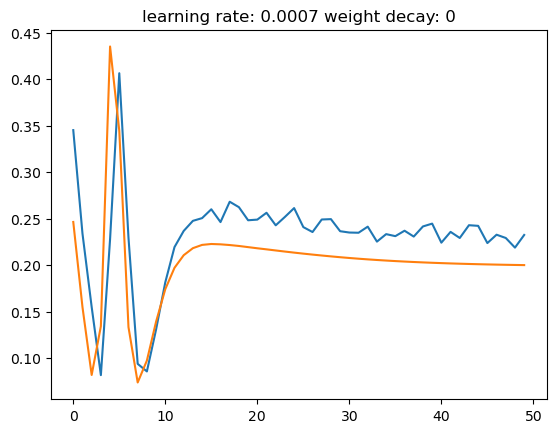

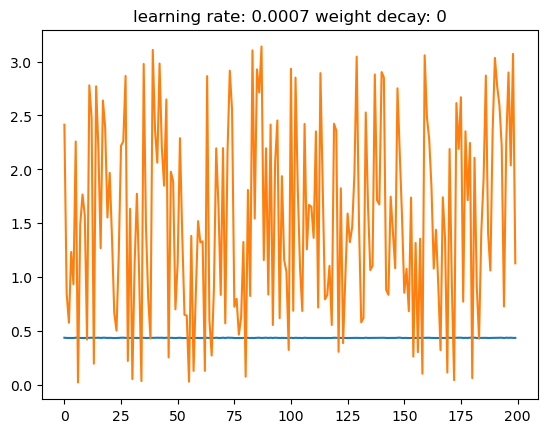

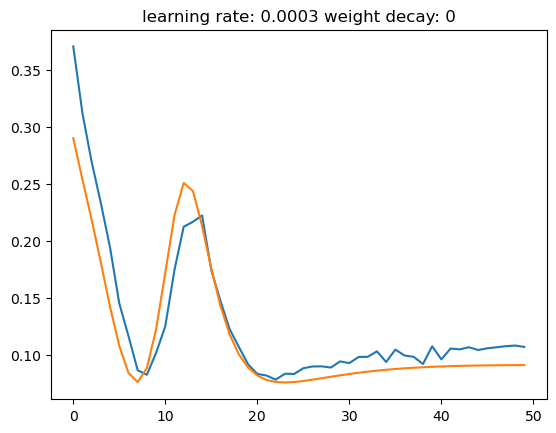

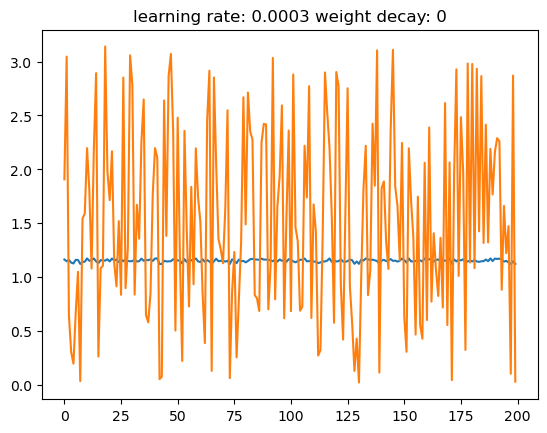

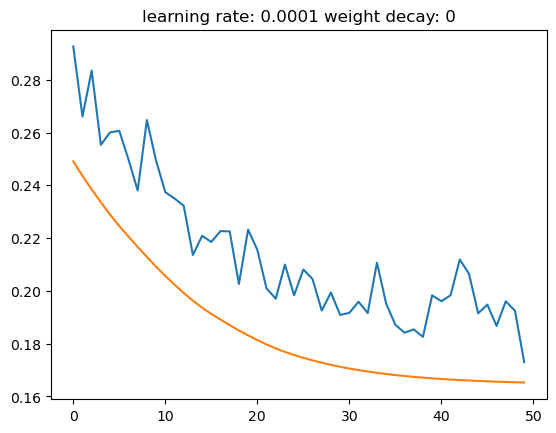

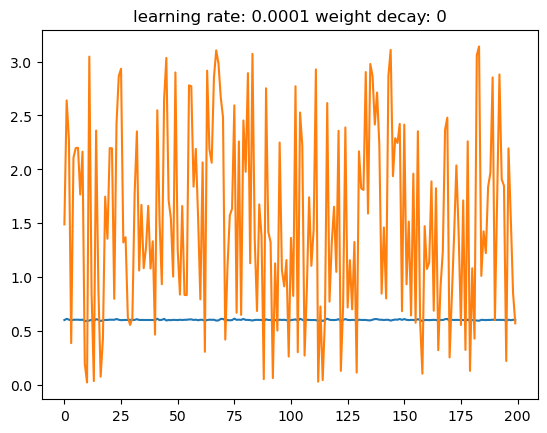

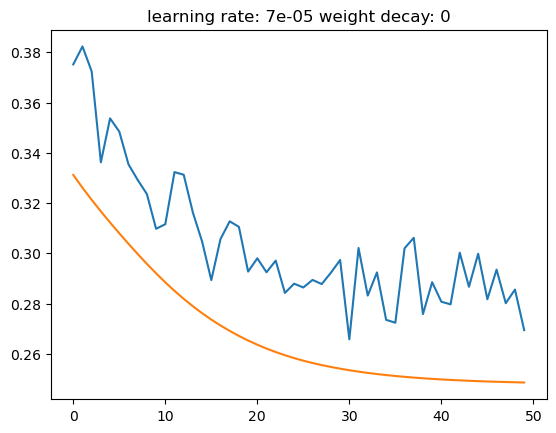

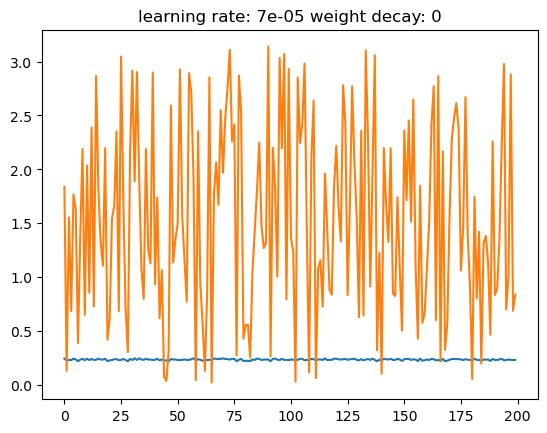

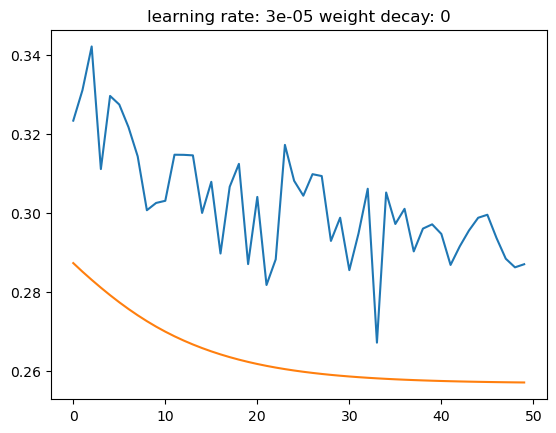

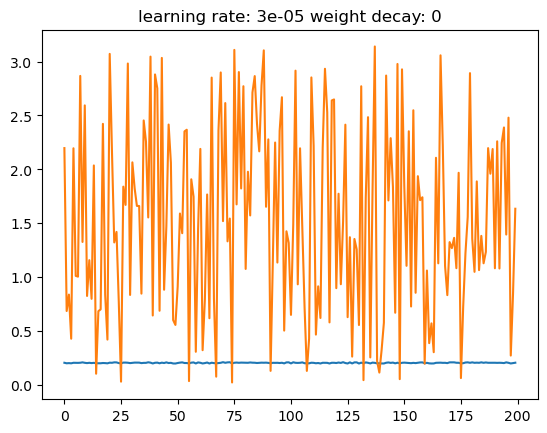

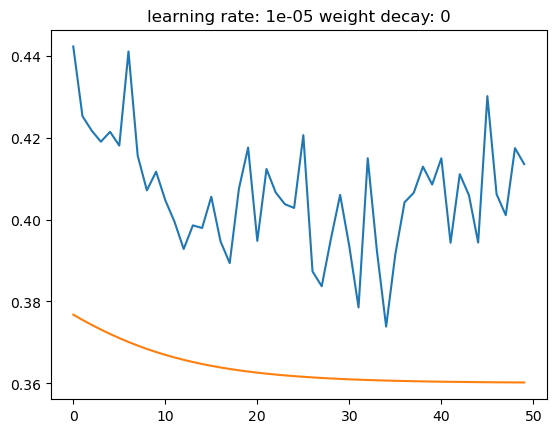

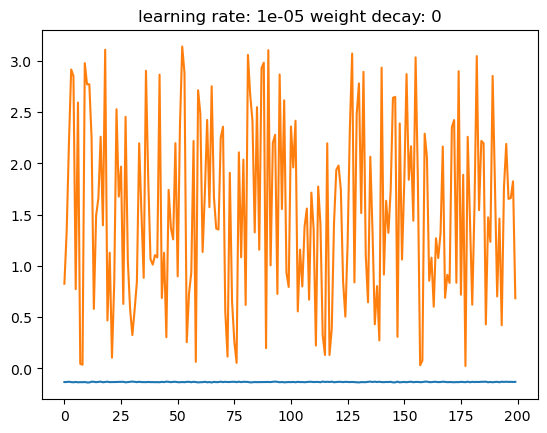

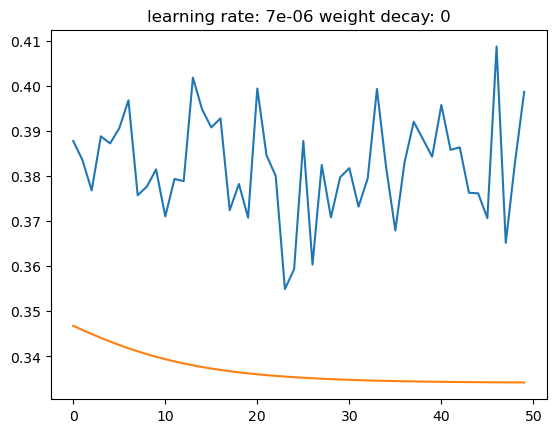

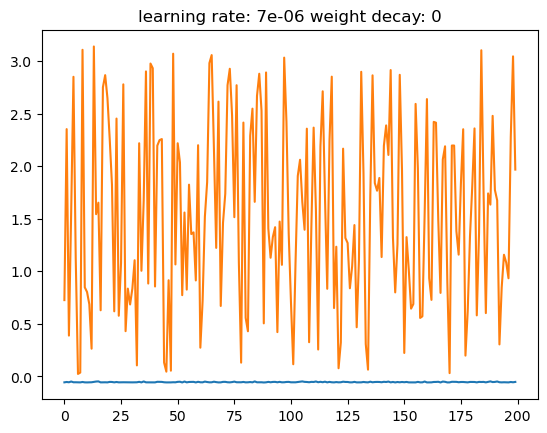

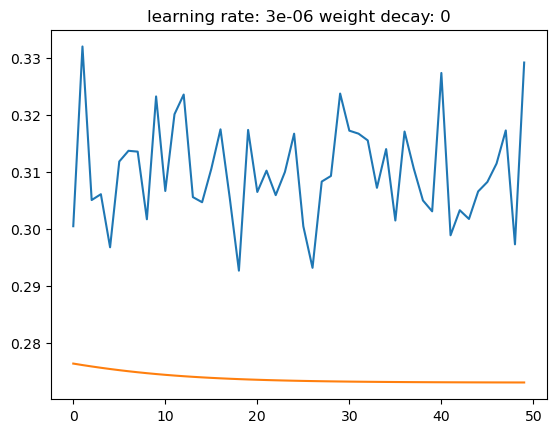

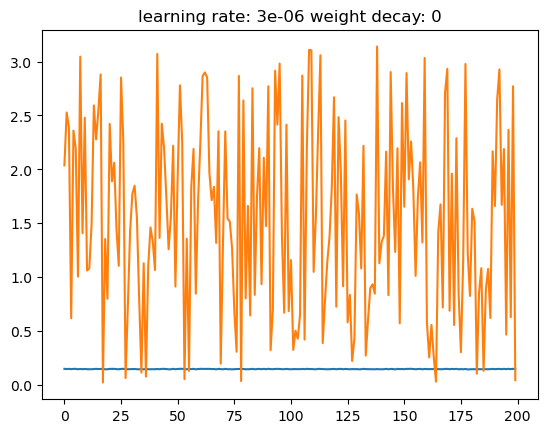

In [297]:
wd = 0
for lr in [1e-3,7e-4,3e-4,1e-4,7e-5,3e-5,1e-5,7e-6,3e-6]:
    #lr = 1e-3
    #wd = 1e-3
    del model
    model = Net()

    epochs = 50
    optimizer = torch.optim.Adam(
            model.parameters(),
            lr           = lr,
            #weight_decay = wd
        )

    gamma = 0.9#0.85
    scheduler_step_size = 1
    scheduler = lr_scheduler.StepLR(
        optimizer, 
        step_size = scheduler_step_size, 
        gamma     = gamma)

    train_losses = []
    val_losses   = []
    lrs          = []
    for epoch in range(epochs):
        train_loss = train_one_epoch(model,optimizer)
        val_loss   = validate_one_epoch(model,optimizer)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()
        #print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

    txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
    plt.title(txt)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.show()

    for batch in validation_generator:
        break
    output = model(batch[0])
    output
    plt.title(txt)
    plt.plot(output.detach().numpy()*3.1415926)
    plt.plot(batch[1].detach().numpy()*3.1415926)
    plt.show()

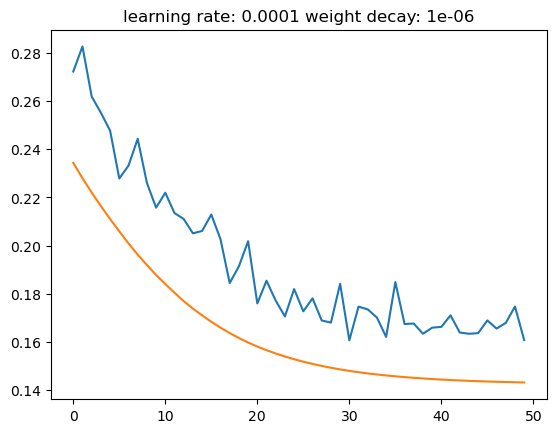

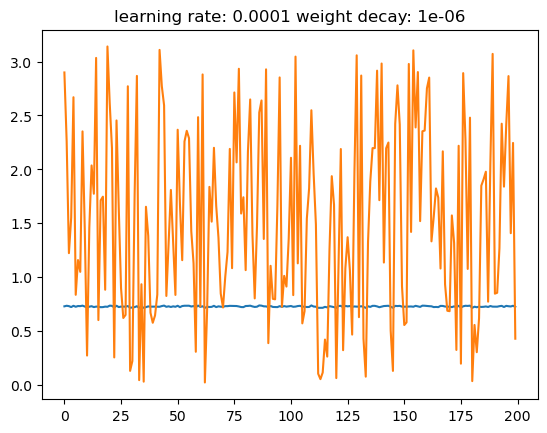

In [292]:
for lr in [1e-4]:
    for wd in [1e-6]:
        #lr = 1e-3
        #wd = 1e-3
        del model
        model = Net()
        
        epochs = 50
        optimizer = torch.optim.Adam(
                model.parameters(),
                lr           = lr,
                weight_decay = wd
            )

        #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        gamma = 0.9#0.85
        scheduler_step_size = 1
        scheduler = lr_scheduler.StepLR(
            optimizer, 
            step_size = scheduler_step_size, 
            gamma     = gamma)

        # scheduler = lr_scheduler.ExponentialLR(
        #     optimizer, 
        #     #step_size = scheduler_step_size, 
        #     gamma     = gamma)

        train_losses = []
        val_losses   = []
        lrs          = []
        for epoch in range(epochs):
            train_loss = train_one_epoch(model,optimizer)
            val_loss   = validate_one_epoch(model,optimizer)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            lrs.append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step()
            #print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

        txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
        plt.title(txt)
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.show()
        
        for batch in validation_generator:
            break
        output = model(batch[0])
        output
        plt.title(txt)
        plt.plot(output.detach().numpy()*3.1415926)
        plt.plot(batch[1].detach().numpy()*3.1415926)
        plt.show()

In [ ]:
lr = 1e-3
wd = 1e-3
epochs = 50
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd
    )

#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

gamma = 0.9#0.85
scheduler_step_size = 1
scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size = scheduler_step_size, 
    gamma     = gamma)

# scheduler = lr_scheduler.ExponentialLR(
#     optimizer, 
#     #step_size = scheduler_step_size, 
#     gamma     = gamma)

In [249]:
train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

EPOCH:  1  Train loss:  0.3915  Val loss:  1.4234  LR:  0.0009
EPOCH:  2  Train loss:  0.9241  Val loss:  2.9026  LR:  0.00081
EPOCH:  3  Train loss:  4.0687  Val loss:  1.1827  LR:  0.000729
EPOCH:  4  Train loss:  2.1032  Val loss:  4.7321  LR:  0.0006561
EPOCH:  5  Train loss:  3.7452  Val loss:  14.1136  LR:  0.00059049
EPOCH:  6  Train loss:  23.7268  Val loss:  12.2929  LR:  0.000531441
EPOCH:  7  Train loss:  5.8111  Val loss:  18.9997  LR:  0.0004782969
EPOCH:  8  Train loss:  35.8289  Val loss:  7.7188  LR:  0.0004304672
EPOCH:  9  Train loss:  66.0951  Val loss:  103.0817  LR:  0.0003874205
EPOCH:  10  Train loss:  255.4729  Val loss:  116.3907  LR:  0.0003486784
EPOCH:  11  Train loss:  139.8103  Val loss:  606.1378  LR:  0.0003138106
EPOCH:  12  Train loss:  730.0201  Val loss:  168.1657  LR:  0.0002824295
EPOCH:  13  Train loss:  791.6396  Val loss:  2909.743  LR:  0.0002541866
EPOCH:  14  Train loss:  2905.6215  Val loss:  615.1415  LR:  0.0002287679
EPOCH:  15  Train los

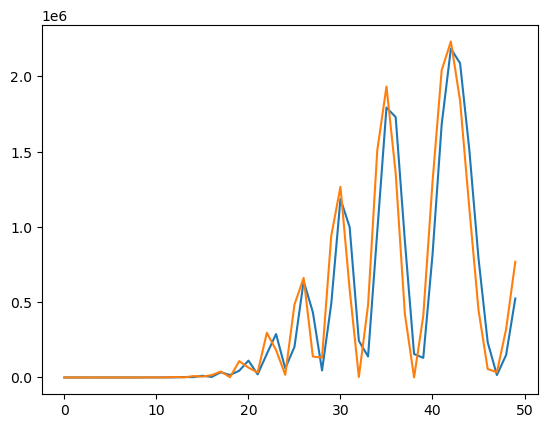

In [250]:
plt.plot(train_losses)
plt.plot(val_losses)

In [251]:
for batch in validation_generator:
    break
output = model(batch[0])
output

tensor([[877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166],
        [877.2166]], grad_fn=<AddmmBackward0>)

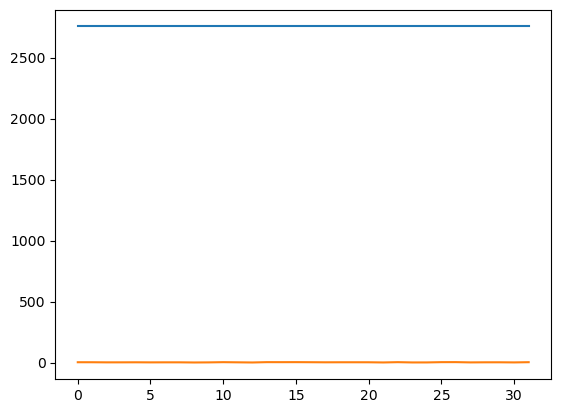

In [252]:
plt.plot(output.detach().numpy()*3.1415926)
plt.plot(batch[1].detach().numpy()*3.1415926)

2.4017561539998047


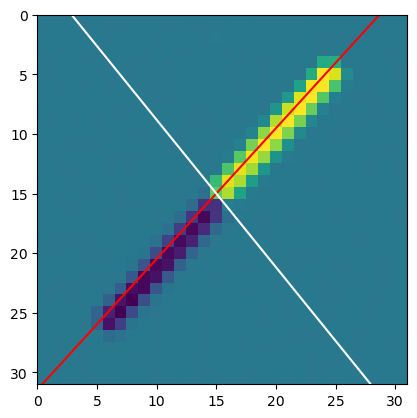

0.5291772435455127


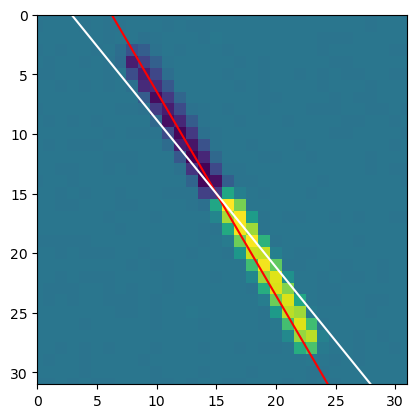

1.4788451912634581


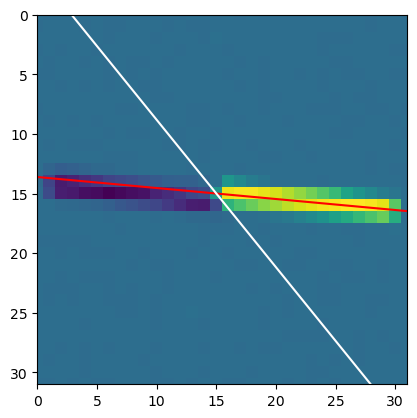

2.3009941812176917


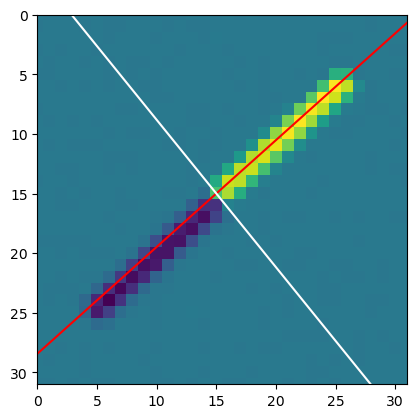

1.716578159980286


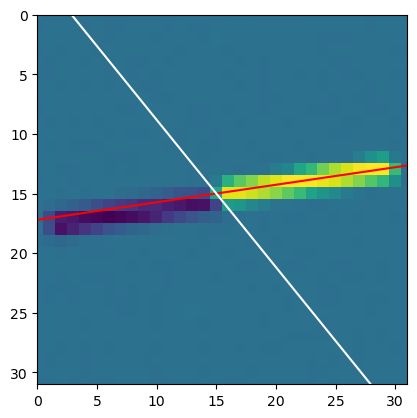

1.4702681655386918


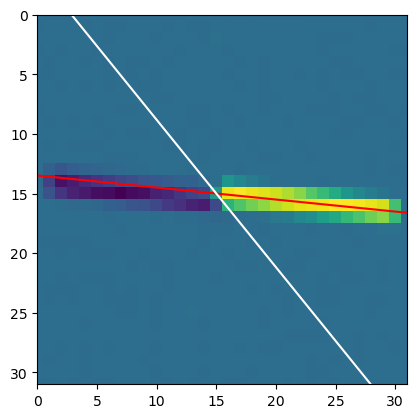

2.509279706568513


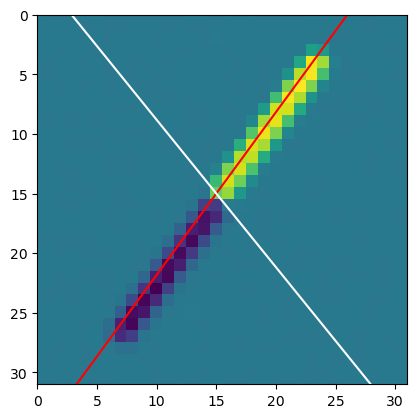

1.4319135370632248


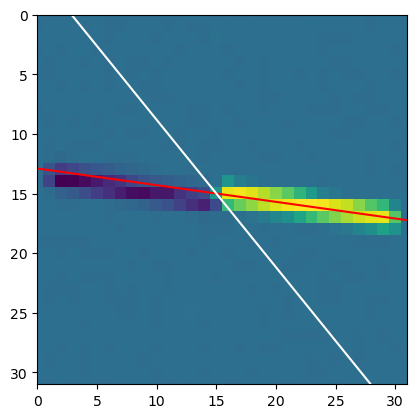

0.7117488790912639


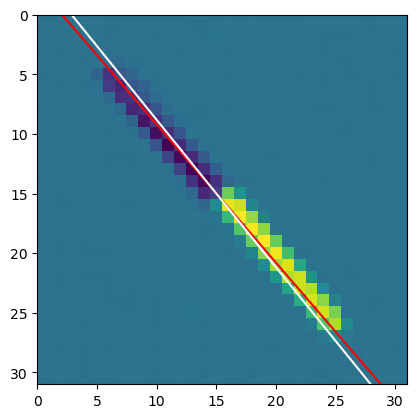

0.9632508206124435


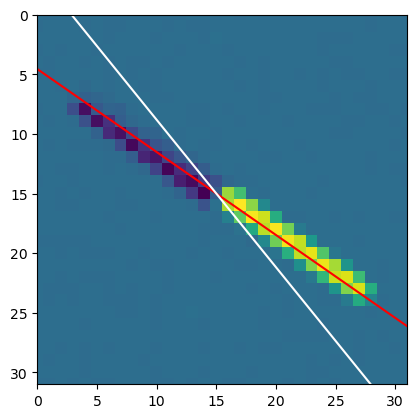

2.071020855387886


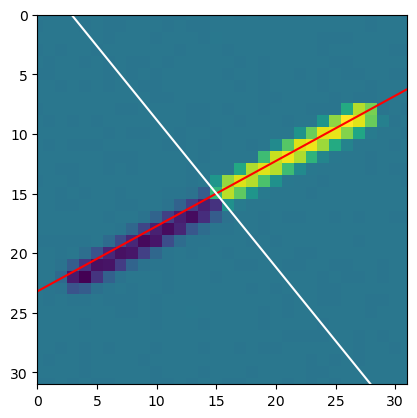

3.090326655980239


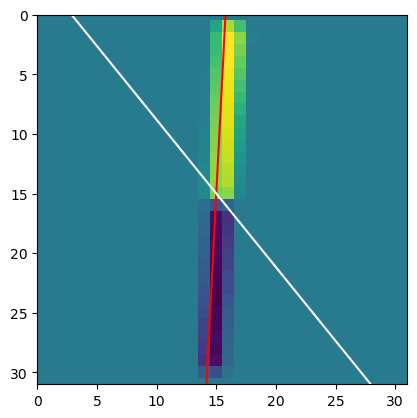

2.956252851757967


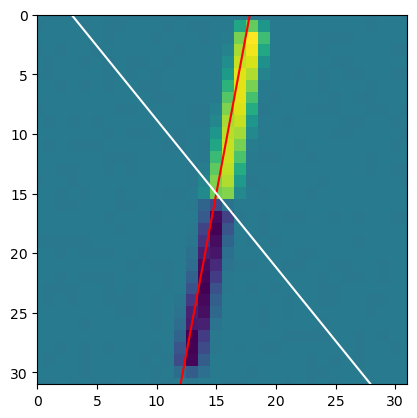

1.4405884997400258


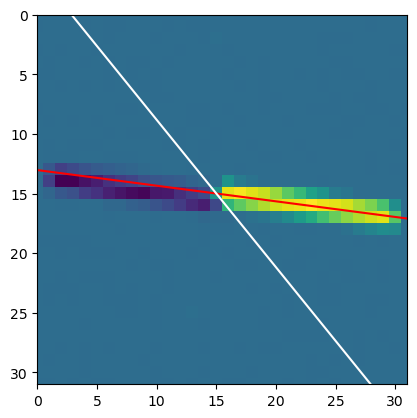

1.3629696481150433


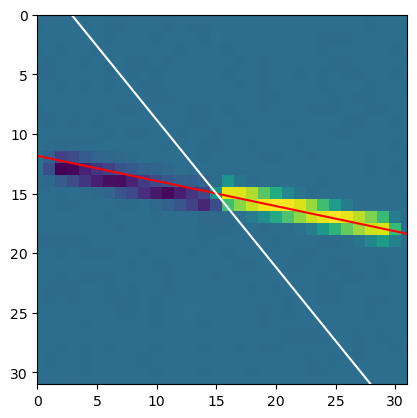

1.4564471237980952


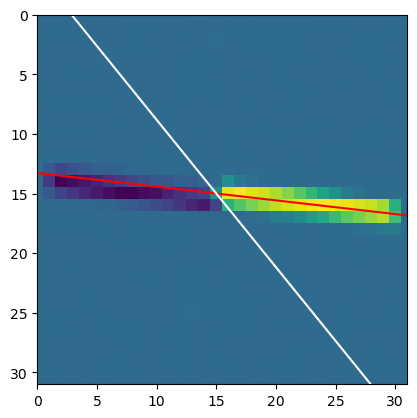

1.9306051211202844


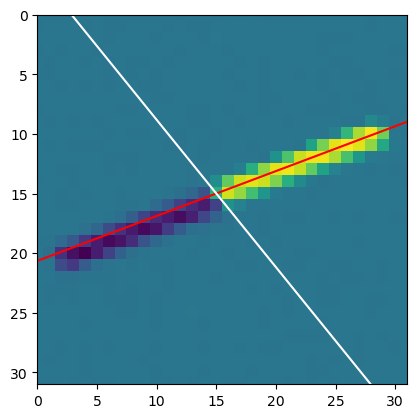

1.7188162645417149


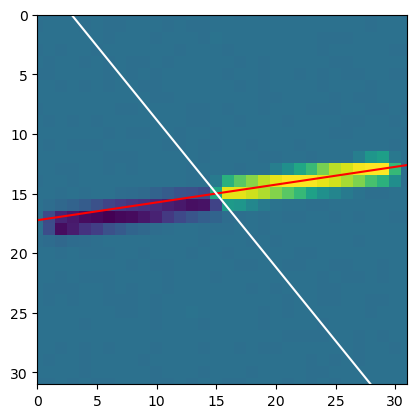

1.47755293666422


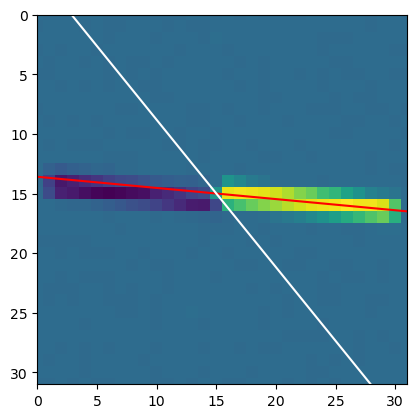

2.25727340352739


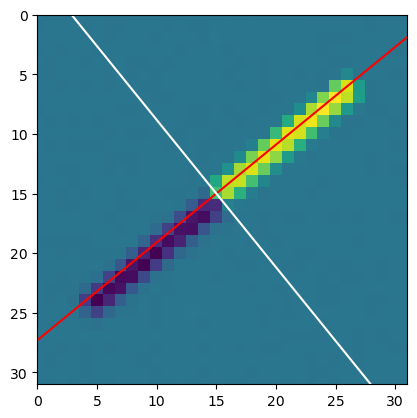

0.9855861406098821


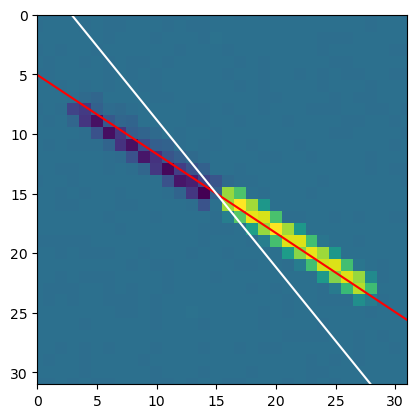

3.0219386525304524


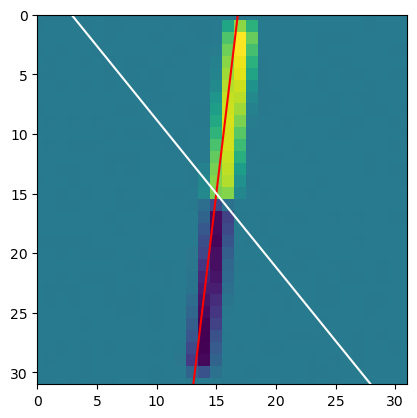

3.0041721848556877


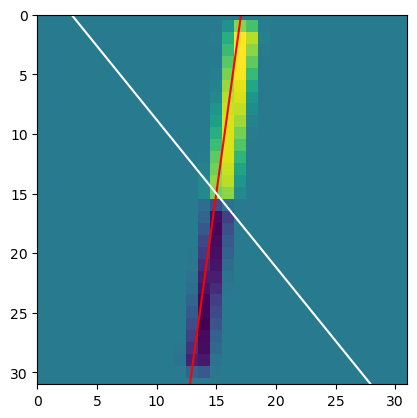

1.3935416990226057


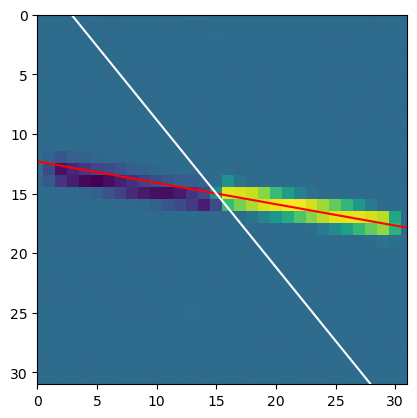

2.4393461755106154


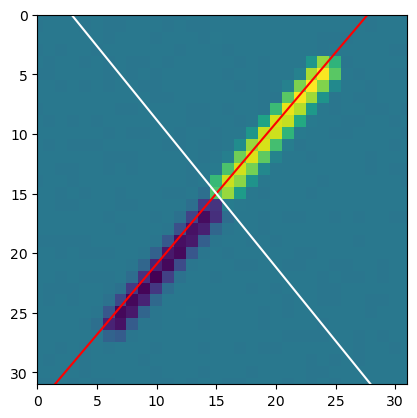

2.9390535902831076


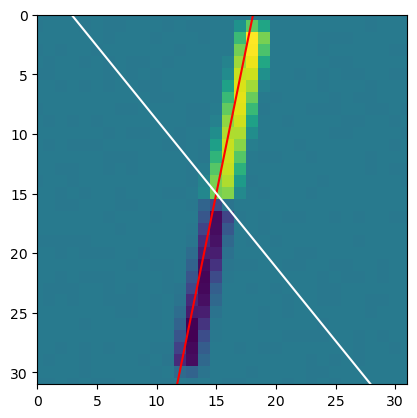

0.5293111344507141


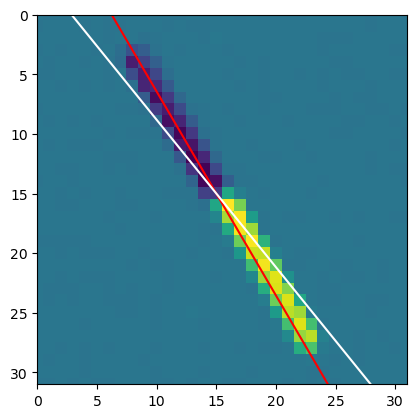

0.38430532949551655


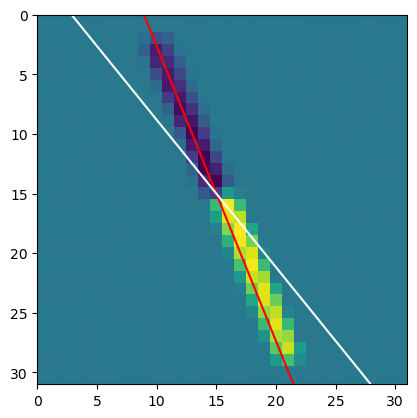

1.7977674502933212


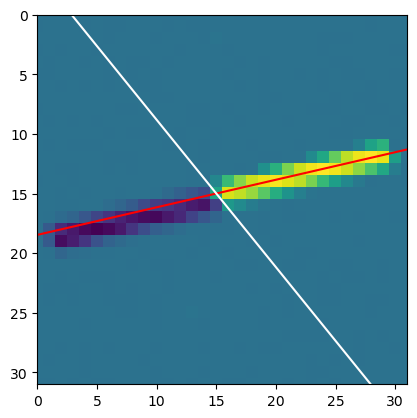

1.6114185832994008


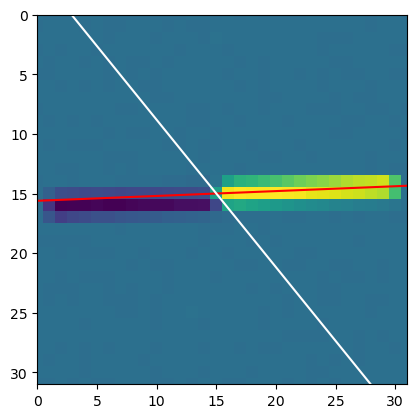

In [253]:
test_IDs = [ random.randint(0,999) for i in range(100) ]

real = []
outputs = []
for ID in test_IDs[:30]:
    input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
    label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
    
    X = torchvision.io.read_image(
                input_dir + str(ID) + ".png "
            ).to(torch.float32)
    plt.imshow(X[1])
    X = X/256.
    
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
        Y = Y[1][0]#/3.1415926
        
    output = float(model(X[1].unsqueeze(0).unsqueeze(0)))*3.1415926
    
    print(Y)
    
    real.append(Y)
    outputs.append(output)
    
    #plt.plot( [16 - 50*math.tan(Y),16 ,16 + 50*math.tan(Y)],[16 - 50, 16,16 + 50], c='r')
    plt.plot( [15 - 50*math.tan(Y),15 ,15 + 50*math.tan(Y)],[15 - 50, 15,15 + 50], c='r')
    plt.plot( [15 - 50*math.tan(output),15 ,15 + 50*math.tan(output)],[15 - 50, 15,15 + 50], c='w')
    
    plt.xlim(0,31)
    plt.ylim(31,0)
    
    #plt.axvline( x = (Y + 1)*16, c='w' )
    #plt.axvline( x = (output + 1.)*16, c='r')
    plt.show()
    
        